# 4.2 손실 함수

In [6]:
import numpy as np

In [2]:
# 오차제곱합 함수 만들기
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [3]:
# 교차 엔트로피 오차 함수 만들기
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [4]:
# MNIST data 불러오기
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

In [5]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [6]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [7]:
# 교차 엔트로피 오차 함수 미니배치에 맞게 바꾸기
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

# 4.3 수치 미분

**수치 미분**: 아주 작은 `차분`으로 근사치로 계산하는 미분 방법

`차분`: 임의의 두 점에서 함수 값의 차이  
cf) 해석적 미분은 오차를 포함하지 않는 '진정한 미분' 값을 구해 준다. 가령  
$y = x^2$의 미분 값은 $\frac{dy}{dx}=2x$

In [2]:
# 중심 차분/ 중앙 차분을 이용한 수치 미분 구현
def numerical_diff(f, x):
    h = 10e-4 # 무작정 작은 값은 반올림 오차로 제대로 계산되지 않는다.
    return (f(x+h)-f(x-h))/(2*h)

# 4.4 기울기

In [1]:
# 기울기 함수 구현
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val
    return grad

In [3]:
# 경사 하강법 구현
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [4]:
# example
def function_2(x):
    return x[0]**2 + x[1]**2

In [7]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x= init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

In [6]:
# gradient_simplenet 불러 들이기
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [9]:
# 정규 분포로 초기화된 2행3렬 매개변수 행렬 출력
net = simpleNet()
print(net.W)

[[ 1.07506934 -0.32563083 -0.96098297]
 [ 0.1567326  -0.67917147  0.00502923]]


In [8]:
# 0.6, 0.9일 때 예측 값
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[ 0.12003085 -2.25618717 -0.01798226]


In [10]:
np.argmax(p)

0

In [11]:
# 예측값과 정답 셋의 차의 손실함수 값
t = np.array([0, 0, 1])
net.loss(x, t)

1.7369435262894557

In [13]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.41081764  0.08354753 -0.49436516]
 [ 0.61622645  0.12532129 -0.74154774]]


# 4.5 학습 알고리즘 구현하기

## 4.5.1 2층 신경망 클래스 구현하기

In [14]:
# two_layer_net.py 옮겨 오기
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient

In [15]:
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [17]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape

(784, 100)

In [18]:
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(100,)
(100, 10)
(10,)


In [19]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [20]:
t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t)

train acc, test acc | 0.09915, 0.1009
train acc, test acc | 0.78825, 0.7944
train acc, test acc | 0.8751333333333333, 0.8787
train acc, test acc | 0.8974833333333333, 0.9008
train acc, test acc | 0.90835, 0.9101
train acc, test acc | 0.91485, 0.9171
train acc, test acc | 0.9184666666666667, 0.9224
train acc, test acc | 0.9238333333333333, 0.9266
train acc, test acc | 0.9269833333333334, 0.9302
train acc, test acc | 0.9303666666666667, 0.9329
train acc, test acc | 0.9339666666666666, 0.935
train acc, test acc | 0.9364166666666667, 0.937
train acc, test acc | 0.9393, 0.9402
train acc, test acc | 0.9410166666666666, 0.9411
train acc, test acc | 0.9440166666666666, 0.9436
train acc, test acc | 0.94525, 0.9445
train acc, test acc | 0.9473833333333334, 0.9465


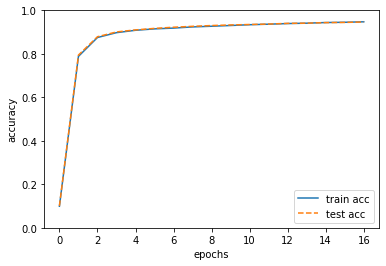

In [22]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
